In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [2]:
!pip install --upgrade pyfluidsynth

  Preparing metadata (setup.py) ... done
  Created wheel for pyfluidsynth: filename=pyFluidSynth-1.3.3-py3-none-any.whl size=19185 sha256=8db8eebae226097604b111f84b67af76a9206159078a8e15a694a92f9db262a7
  Stored in directory: /root/.cache/pip/wheels/e6/9c/2b/b4b194cbb100d6f20136a22b2f76cd329b1a21139ed26c9775
Successfully built pyfluidsynth


In [3]:
!pip install pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=10243b6d5a3cfcb2ecff24c49a9123fd697e2a89eb1120965ed846af28f03d24
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional


In [5]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [6]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )


59243107/59243107 [==============================] - 1s 0us/step


In [7]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [8]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2009/MIDI-Unprocessed_03_R1_2009_03-08_ORIG_MID--AUDIO_03_R1_2009_03_R1_2009_08_WAV.midi


In [9]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [10]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [11]:
display_audio(pm)

In [68]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


### extraxt notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

In [13]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [14]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     63  0.957031  1.022135  0.000000  0.065104
1     89  0.960938  1.002604  0.003906  0.041667
2     75  0.963542  0.985677  0.002604  0.022135
3     80  0.964844  1.010417  0.001302  0.045573
4     77  0.968750  1.011719  0.003906  0.042969

In [15]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#4', 'F6', 'D#5', 'G#5', 'F5', 'C6', 'G#4', 'C5', 'C4', 'G#2'],
      dtype='<U3')

In [16]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

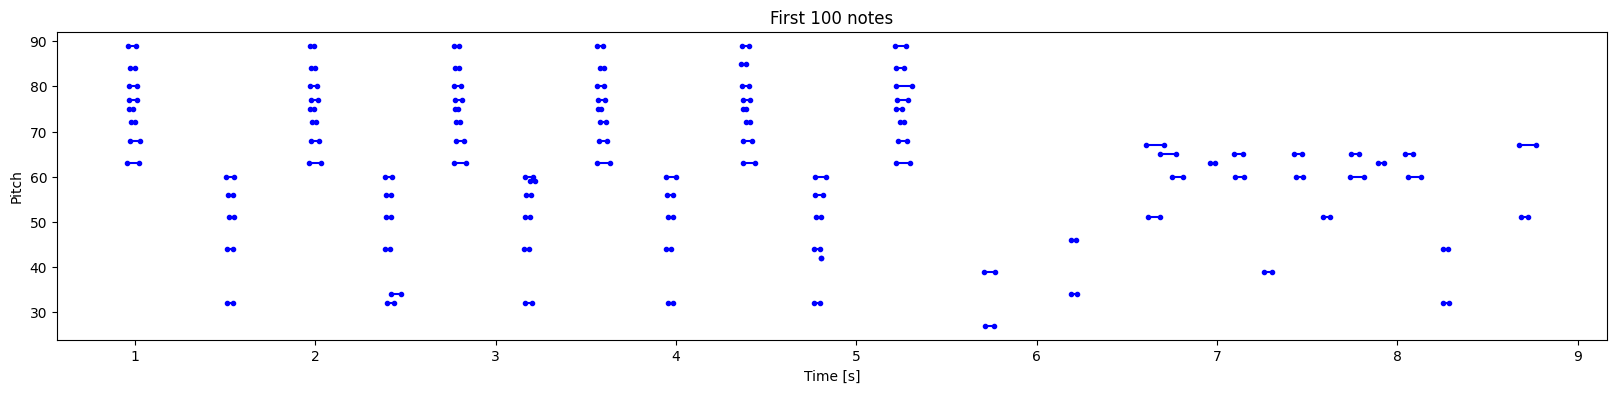

In [17]:
plot_piano_roll(raw_notes, count=100)

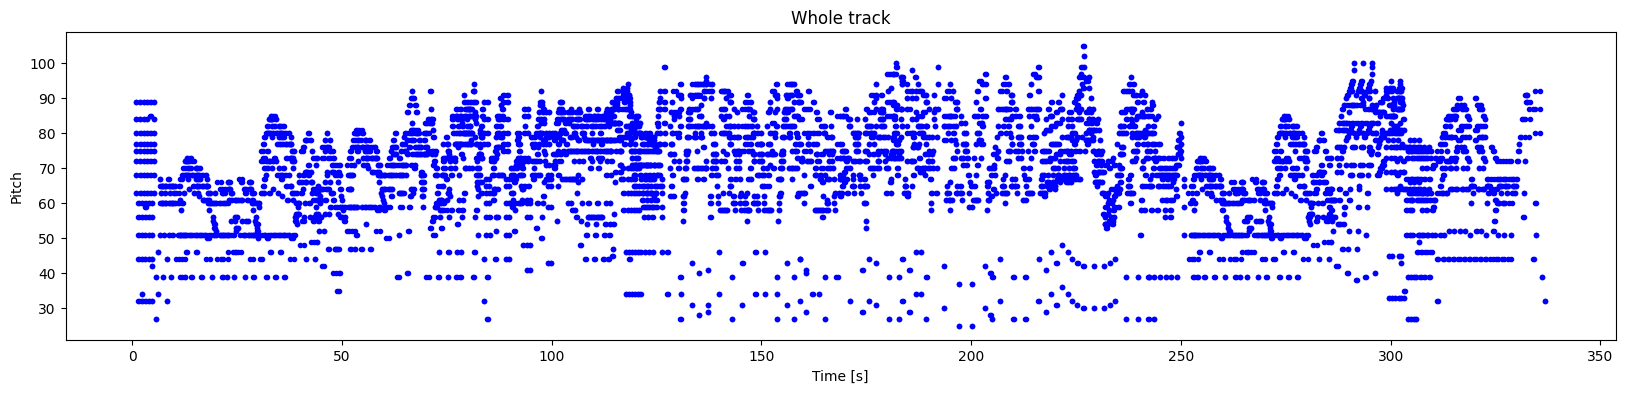

In [18]:
plot_piano_roll(raw_notes)

In [19]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

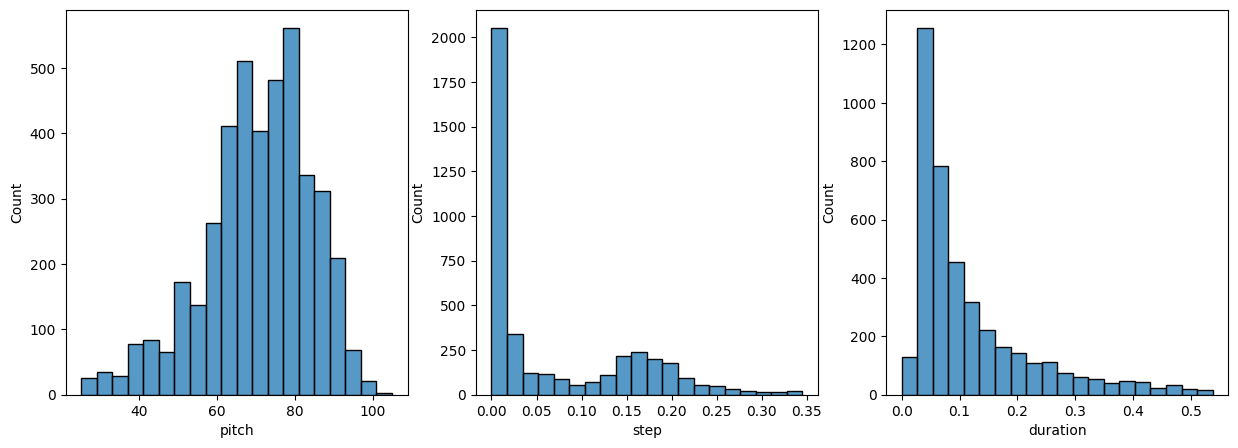

In [20]:
plot_distributions(raw_notes)

In [61]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100  # note loudness
) -> pretty_midi.PrettyMIDI:

    # Create a PrettyMIDI object
    pm = pretty_midi.PrettyMIDI()
    # Initialize the instrument
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name)
    )

    prev_start = 0.0
    # Iterate over the rows of the DataFrame
    for i, note in notes.iterrows():
        step = float(note['step'])
        duration = float(note['duration'])
        start = prev_start + step
        end = start + duration
        # Create a PrettyMIDI Note
        midi_note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        # Append the note to the instrument
        instrument.notes.append(midi_note)
        # Update prev_start to the end of the current note
        prev_start = start

    # Append the instrument to the PrettyMIDI object
    pm.instruments.append(instrument)
    # Write the MIDI file
    pm.write(out_file)
    return pm


In [22]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [23]:
display_audio(example_pm)

### Create the training dataset

In [24]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [25]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 30493


In [26]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [27]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [28]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [30]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.46875    0.         0.48177083]
 [0.3984375  0.00130208 0.30729167]
 [0.4296875  0.0078125  0.50520833]
 [0.28125    0.00390625 0.06640625]
 [0.375      0.00130208 0.05598958]
 [0.46875    1.16536458 0.04166667]
 [0.3984375  0.00260417 0.03645833]
 [0.375      0.01302083 0.03776042]
 [0.4296875  0.00260417 0.03385417]
 [0.28125    0.         0.03645833]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=67.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.12109375>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.11588541666666696>}


In [31]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [32]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

### Create and train the model

In [33]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [34]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [35]:
losses = model.evaluate(train_ds, return_dict=True)
losses

476/476 [==============================] - 8s 3ms/step - loss: 5.1286 - duration_loss: 0.2046 - pitch_loss: 4.8560 - step_loss: 0.0680


{'loss': 5.128563404083252,
 'duration_loss': 0.20459626615047455,
 'pitch_loss': 4.855992794036865,
 'step_loss': 0.06797066330909729}

In [36]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [37]:
model.evaluate(train_ds, return_dict=True)

476/476 [==============================] - 2s 3ms/step - loss: 0.5154 - duration_loss: 0.2046 - pitch_loss: 4.8560 - step_loss: 0.0680


{'loss': 0.5153666734695435,
 'duration_loss': 0.20459626615047455,
 'pitch_loss': 4.855992794036865,
 'step_loss': 0.06797066330909729}

In [38]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [39]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
476/476 [==============================] - 7s 5ms/step - loss: 0.4010 - duration_loss: 0.1287 - pitch_loss: 4.1467 - step_loss: 0.0649
Epoch 2/50
476/476 [==============================] - 2s 5ms/step - loss: 0.3863 - duration_loss: 0.1219 - pitch_loss: 4.0200 - step_loss: 0.0634
Epoch 3/50
476/476 [==============================] - 3s 6ms/step - loss: 0.3808 - duration_loss: 0.1202 - pitch_loss: 3.9842 - step_loss: 0.0614
Epoch 4/50
476/476 [==============================] - 2s 5ms/step - loss: 0.3746 - duration_loss: 0.1175 - pitch_loss: 3.9477 - step_loss: 0.0597
Epoch 5/50
476/476 [==============================] - 2s 5ms/step - loss: 0.3726 - duration_loss: 0.1165 - pitch_loss: 3.9368 - step_loss: 0.0592
Epoch 6/50
476/476 [==============================] - 3s 6ms/step - loss: 0.3680 - duration_loss: 0.1143 - pitch_loss: 3.9303 - step_loss: 0.0572
Epoch 7/50
476/476 [==============================] - 2s 5ms/step - loss: 0.3642 - duration_loss: 0.1121 - pitch_loss: 3.921

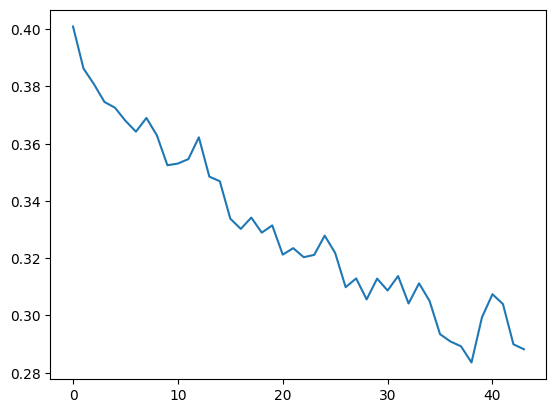

In [40]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

### Generate notes

In [70]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0,
    min_step: float = 0.02  # Minimum step to ensure non-zero
) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(min_step, step)  # Ensure a minimum step value
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)

In [71]:
num_predictions = 360

# Adjust the `temperature` variable to control the randomness of the generated notes.
temperature = 3

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))


1/1 [==============================] - 0s 19ms/step


In [72]:
generated_notes.head(10)

pitch      step  duration     start       end
0     60  0.116417  0.086434  0.116417  0.202851
1     34  0.020000  0.110865  0.136417  0.247282
2     88  0.020000  0.361782  0.156417  0.518199
3    100  0.020000  0.257758  0.176417  0.434175
4    100  0.020000  0.240688  0.196417  0.437105
5     88  0.020000  0.239956  0.216417  0.456373
6    101  0.020000  0.253551  0.236417  0.489968
7     85  0.020000  0.229187  0.256417  0.485604
8     80  0.020000  0.242704  0.276417  0.519121
9    100  0.020000  0.264608  0.296417  0.561025

In [73]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

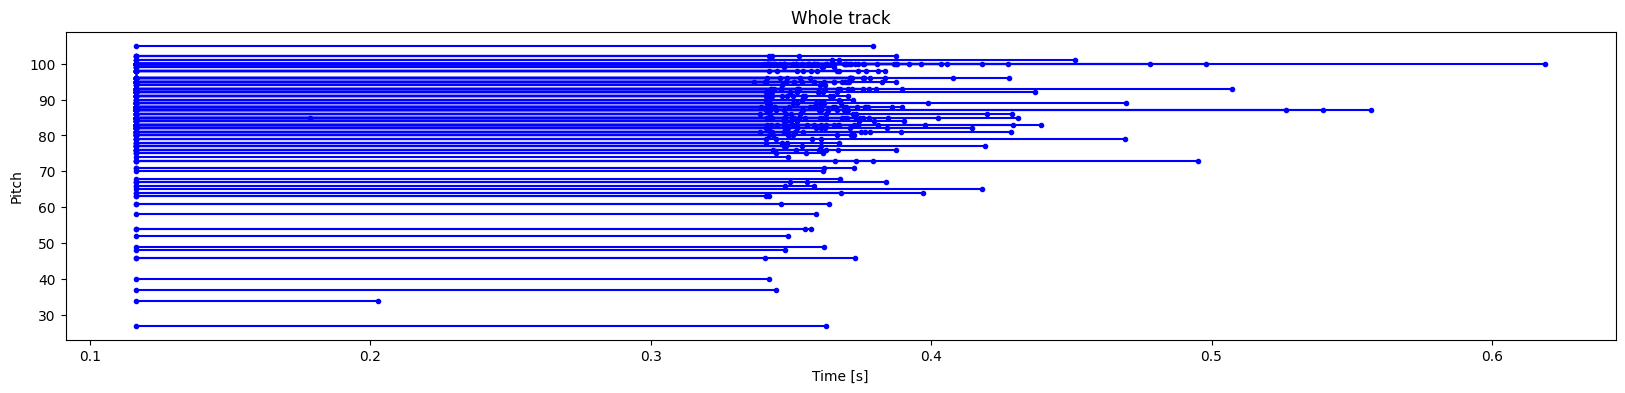

In [56]:
plot_piano_roll(generated_notes)

In [74]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>